In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import SplineTransformer
from torch.utils.data import DataLoader, TensorDataset
from collections import OrderedDict
from torch import nn
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from collections import Counter
import glob
import cv2
import os

In [2]:
def proc_brain(imgdir, w, h):

    WIDTH, HEIGHT = w, h
    
    x = []
    for i in range(len(imgdir)):
        # Read and resize image
        full_size_image = cv2.imread(imgdir[i])
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC)/255.0) 

    return x

def diag_mat_weights(dimp, type = 'first'):
    if type == 'first':
        dg = np.zeros((dimp-1, dimp))
        for i in range(dimp-1):
            dg[i,i] = -1
            dg[i,i+1]= 1
    elif type == 'second':
        dg = np.zeros((dimp-2, dimp))
        for i in range(dimp-2):
            dg[i,i] = -1
            dg[i,i+1]= 2
            dg[i,i+2]= -1
    else:
        pass
    return torch.Tensor(dg)
    
class PRODBSplineLayerMultiFeature(nn.Module):
    def __init__(self, input_dim, degree, num_knots, output_dim, num_neurons, bias = True):
        super(PRODBSplineLayerMultiFeature, self).__init__()
        self.degree = degree
        self.num_knots = num_knots
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_neurons = num_neurons
        
        if input_dim == 2:
            self.control_p = nn.Parameter(torch.randn(self.num_knots**2, self.output_dim))
        else:
            self.control_p = nn.Parameter(torch.randn(self.num_knots, self.num_neurons))
        if bias:
            self.bias = nn.Parameter(torch.randn(self.num_neurons))
        else:
            self.register_parameter('bias', None)
            
        self.inter = {}
    
    def basis_function(self, x, i, k, t):
    
        # Base case: degree 0 spline
        if k == 0:
            return ((t[i] <= x) & (x < t[i + 1])).float()
    
        # Recursive case
        denom1 = t[i + k] - t[i]
        denom2 = t[i + k + 1] - t[i + 1]
    
        term1 = 0
        if denom1 != 0:
            term1 = (x - t[i]) / denom1 * self.basis_function(x, i, k - 1, t)
    
        term2 = 0
        if denom2 != 0:
            term2 = (t[i + k + 1] - x) / denom2 * self.basis_function(x, i + 1, k - 1, t)
    
        return term1 + term2
    
    def forward(self, x):
        batch_size, num_features = x.size()
        device = x.device
        
        # Create knot vector
        # knots = torch.linspace(0, 1, self.num_knots + self.degree + 1).to(device)
        knots = torch.cat([
                        torch.zeros(self.degree),               # Add repeated values at the start for clamping
                        torch.linspace(0, 1, self.num_knots - self.degree + 1),  # Uniform knot spacing in the middle
                        torch.ones(self.degree)                 # Add repeated values at the end for clamping
                    ]).to(device)
        # Apply B-spline basis functions for each feature
        basises = []
    
        
        for feature in range(num_features):
            # Calculate B-spline basis functions for this feature
            basis = torch.stack([self.basis_function(x[:, feature], i, self.degree, knots) 
                                 for i in range(self.num_knots)], dim=-1)
            basises.append(basis)
            
        
        if num_features == 1:
            tout = basises[0] @ self.control_p
            self.inter['basic'] = basises[0].T
        else:
            self.inter['basic'] = torch.reshape(torch.stack(basises, dim = 1), (batch_size, self.num_knots * self.num_neurons)).T
            basises = torch.stack(basises)
            tout = basises.permute(1,2,0) * self.control_p
            tout = tout.sum(dim =1)
                
        if self.bias is not None:
            tout += self.bias        
            
        return tout
        
class NormLayer(nn.Module):
    def __init__(self):
        super(NormLayer, self).__init__()

    def forward(self, x):
        min_val = torch.min(x, axis = 1).values.reshape(-1,1)
        max_val = torch.max(x, axis = 1).values.reshape(-1,1)

        x = (x - min_val)/(max_val - min_val)  # Rescale to [0, 1]
        return x.detach()
        
def ECM(model, num_neurons, num_knots, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4, L = None):
    lambdab = initial_lambda
    sigma = initial_sigma
    xi = initial_xi

    if L == 1:
        B = model.inter['ebasic']
        By = model.inter['basic']
        WB = model.sp1.control_p
    else:
        B = model.inter['ebasic2']
        By = model.inter['basic2']
        WB = model.sp2.control_p
        
    DB = diag_mat_weights(WB.size()[0]).to(device)
    size = B.size()[1]
    S = DB.T @ DB
    Cov_a = (xi**2)* torch.linalg.pinv(S)
    Cov_e = torch.eye(size*num_neurons)* sigma
    
    block_y = torch.reshape(By, (-1,1))
    flatB = B.view(num_neurons, num_knots, size)
        
    sqr_xi= 0
    sqr_sig = 0
    
    for i in range(num_neurons):
        Ncov = (Cov_a -(Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)]) @ flatB[i].T @ Cov_a))
        Nmu = (Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)])) @ By[:,i].reshape(-1,1)
        
        first_xi = S @ Ncov
        second_xi = (Nmu.T @ S @ Nmu)
        sqr_xi += torch.trace(first_xi) + second_xi
            
        first_sig = torch.norm(By[:,i])
        second_sig = 2 * (By[:,i] @ flatB[i].T) @ Nmu 
        third_sig = torch.trace((flatB[i] @ flatB[i].T) @ Ncov)
        four_sig = (Nmu.T @ flatB[i] @ flatB[i].T @ Nmu)
        
        sqr_sig += (first_sig + second_sig + third_sig + four_sig)
    
    sqr_xi /= num_neurons
    sqr_sig /= (num_neurons*size)
    
    Lambda = sqr_sig/sqr_xi
    
    return Lambda.item()

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Data Preprocessing

In this section, we will load the brain tumor MRI Images and resize it to 224x224 pixels and ensure the images are in gray scale for numerical stability. The brain tumor MRI can be found in following link: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data

In [3]:
train1 = glob.glob('/Users/a080528/Downloads/chest_xray/train/PNEUMONIA/*.jpeg')
train2 = glob.glob('/Users/a080528/Downloads/chest_xray/train/NORMAL/*.jpeg')

test1 = glob.glob('/Users/a080528/Downloads/chest_xray/test/PNEUMONIA/*.jpeg')
test2 = glob.glob('/Users/a080528/Downloads/chest_xray/test/NORMAL/*.jpeg')

train = [train1, train2]; test = [test1, test2]

trainx = []
for f in train:
    x = proc_brain(f, 224, 224)
    trainx.append(x)

testx = []
for f in test:
    x = proc_brain(f, 224, 224)
    testx.append(x)

Xtraind = np.concatenate((np.array(trainx[0]), np.array(trainx[1])))
y_train = np.array([1]*len(trainx[0]))
y_train = np.concatenate((y_train, [0]*len(trainx[1])))
Xtestd = np.concatenate((np.array(testx[0]), np.array(testx[1])))
y_test = np.array([1]*len(testx[0]))
y_test = np.concatenate((y_test, [0]*len(testx[1])))

In [ ]:
"""
In this block, you can customize the number of training size and testing size. According to your setting, we will 
randomly select the assigned number from image dataset. In this demo, we randomly select 500 images and 300 images
from training and testing dataset respectively. Besides, in order to fulfill the requirement of Pytorch, we need to
change the data to suitable type.

"""

trainsize = len(Xtraind); testsize = len(Xtestd)

np.random.seed(42)
trainid = np.random.choice(len(Xtraind), trainsize)
testid = np.random.choice(len(Xtestd), testsize)

print(f"(Training) Number of glioma image: {Counter(y_train[trainid])[0]} |  Number of non-tumor image: {Counter(y_train[trainid])[1]} ")
print(f" (Testing) Number of glioma image: {Counter(y_test[testid])[0]} |  Number of non-tumor image: {Counter(y_test[testid])[1]} ")

X_train = torch.Tensor(Xtraind[trainid]).permute(0, 3, 1, 2); y_train = torch.Tensor(y_train[trainid]).type(torch.LongTensor)
X_test = torch.Tensor(Xtestd[testid]).permute(0, 3, 1, 2); y_test = torch.Tensor(y_test[testid]).type(torch.LongTensor)

## Brain

In [5]:
train1 = glob.glob('/Users/a080528/Downloads/BrainTumor/Training/glioma/*.jpg')
train2 = glob.glob('/Users/a080528/Downloads/BrainTumor/Training/notumor/*.jpg')
test1 = glob.glob('/Users/a080528/Downloads/BrainTumor/Testing/glioma/*.jpg')
test2 = glob.glob('/Users/a080528/Downloads/BrainTumor/Testing/notumor/*.jpg')

train = [train1, train2]; test = [test1, test2]

trainx = []
for f in train:
    x = proc_brain(f, 224, 224)
    trainx.append(x)

testx = []
for f in test:
    x = proc_brain(f, 224, 224)
    testx.append(x)

In [6]:
Xtraind = np.concatenate((np.array(trainx[0]), np.array(trainx[1])))
y_train = np.array([1]*len(trainx[0]))
y_train = np.concatenate((y_train, [0]*len(trainx[1])))
Xtestd = np.concatenate((np.array(testx[0]), np.array(testx[1])))
y_test = np.array([1]*len(testx[0]))
y_test = np.concatenate((y_test, [0]*len(testx[1])))

In [7]:
"""
In this block, you can customize the number of training size and testing size. According to your setting, we will 
randomly select the assigned number from image dataset. In this demo, we randomly select 500 images and 300 images
from training and testing dataset respectively. Besides, in order to fulfill the requirement of Pytorch, we need to
change the data to suitable type.

"""

trainsize = 500; testsize = 300

np.random.seed(123)
trainid = np.random.choice(len(Xtraind), trainsize)
testid = np.random.choice(len(Xtestd), testsize)

print(f"(Training) Number of glioma image: {Counter(y_train[trainid])[0]} |  Number of non-tumor image: {Counter(y_train[trainid])[1]} ")
print(f" (Testing) Number of glioma image: {Counter(y_test[testid])[0]} |  Number of non-tumor image: {Counter(y_test[testid])[1]} ")

X_train = torch.Tensor(Xtraind[trainid]).permute(0, 3, 1, 2); y_train = torch.Tensor(y_train[trainid]).type(torch.LongTensor)
X_test = torch.Tensor(Xtestd[testid]).permute(0, 3, 1, 2); y_test = torch.Tensor(y_test[testid]).type(torch.LongTensor)

(Training) Number of glioma image: 274 |  Number of non-tumor image: 226 
 (Testing) Number of glioma image: 172 |  Number of non-tumor image: 128 


# Modeling

## CNN + 1 layer DPS

### Model setting

In [8]:
class DNNS1(nn.Module):
    def __init__(self, input_dim, degree, num_knots, num_neurons, output_dim, bias):
        super(DNNS1, self).__init__()
        self.num_neurons = num_neurons
        self.num_knots = num_knots
        self.ln1 = nn.Linear(input_dim, num_neurons)
        self.nm1 = NormLayer() 
        self.sp1 = PRODBSplineLayerMultiFeature(input_dim = 1, degree = degree, num_knots = num_knots, num_neurons = num_neurons, output_dim= output_dim, bias = True)
        self.ln2 = nn.Linear(num_neurons, output_dim)
        self.inter = {}
        
    def forward(self, x):
        ln1out = self.ln1(x)
        ln1out = self.nm1(ln1out)
        
        device = ln1out.device
        batch_size, _ = x.size()
        
        # # # # # # # # # # # # # #
        #         SPLINE 1        #
        # # # # # # # # # # # # # #
        
        sp1out = self.sp1(ln1out)
        bslist = self.sp1.inter['basic']
        
        self.inter['ebasic'] = bslist
        self.inter['basic'] = sp1out

        ln2out = self.ln2(sp1out)        
        return ln2out

class TumorClassifier(nn.Module):
    def __init__(self, Fin, dg, nk, nm, Fout, bias):
        super(TumorClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.gap = nn.Flatten()
        self.classifier = DNNS1(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
        self.sm = nn.Softmax(dim = 1)
    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        x = self.sm(x)

        return x

In [9]:
"""
Model setting:

`device`: running the program with cpu or gpu
`tmc`: the classifier that equip with DNN-S 
`nm` : number of neuron in DNN-S
`nk` : number of knot in DNN-S
`patientc` : (early-stop crierion) If the model didn't improve in n epoch then stop.
`patientr` : If the model didn't improve in n epoch then decrease learning rate with specific factor.

"""

# experiment setting
Iteration = 10000; bloss_list = []; tor = 1e-5; lr_tor = 1e-6
patientc = 10; patientr = 5; tpat = 0; bloss = 9999
nm = 100; nk = 15; doutput = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model parameter 
tmc = TumorClassifier(Fin = 100352, dg = 3, nk = nk, nm = nm, Fout = doutput, bias = True)
learning_r = 1e-2
optimizer = torch.optim.Adam(tmc.parameters(), lr=learning_r)
criterion = nn.CrossEntropyLoss()

### Model training

In [ ]:
for t in range(Iteration):

    # Forward pass: Compute predicted y by passing x to the modelsp
    pyb_af = tmc(X_train)
    loss = criterion(pyb_af, y_train); bloss_list.append(loss.item())
    
    if (t > 0) and ((bloss_list[t-1]-bloss_list[t])<tor):        
        if (tpat % patientr) == 0:
            learning_r *= 0.2 
            tpat += 1
            #print('Learning rate reduce to ', learning_r)
            optimizer = torch.optim.Adam(tmc.parameters(), lr=learning_r)
            if learning_r <= lr_tor:
                print('Convergence!')
                break
        elif tpat < patientc:
            tpat += 1
            pass
        else:
            print('Convergence!')
            break
        
    else:
        if loss < bloss:
            #torch.save(tmc.state_dict(), './brainimg'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk))
            bloss = loss.item()
            tpat = 0
        tpat += 1

    if tpat == patientc:
        print('Convergence!')
        break
    
    prediction = torch.argmax(pyb_af, axis = 1)
    acc = (torch.argmax(pyb_af, axis = 1) == y_train).sum()/len(y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if(t % 10 == 0):
        print('| Epoch: ',t+1,'/',str(Iteration),' | Loss: ', np.round(loss.item(), 4),' | Acc: ', acc.item())
        if(t % 50 == 0):
            with torch.no_grad():
                print((torch.argmax(tmc(X_test).detach(), axis = 1) == y_test).sum()/len(y_test))

### ECM Tuning

In [170]:
"""

`ECM_epoch`: number of epoch to run the ecm tuning

"""

print("Running the ECM tunning for penalty in each layer")

ECM_epoch = 10
with torch.no_grad():
    eval_model = TumorClassifier(Fin = 100352, dg = 3, nk = nk, nm = nm, Fout = doutput, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./brainimg'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))

    WB = eval_model.classifier.sp1.control_p
    DB = diag_mat_weights(WB.size()[0], 'second').to(device)
    
    BestGCV = np.inf
    n = X_train.size()[0]
    
    for i in range(ECM_epoch):
        eval_model.train()
        MPSy = eval_model(X_train)

        # update following layer except for last layer
        LambdaB1 = ECM(model = eval_model.classifier, num_neurons = nm, num_knots = nk, L = 1)
        
        B1 = eval_model.classifier.inter['ebasic']
        By1 = eval_model.classifier.inter['basic']
        P2 = By1 @ torch.inverse(By1.T @ By1) @ By1.T

        
        size1 = B1.size()[1]
        B1 = B1.view(nk, nm, size1)

        NW1 = torch.empty((nk, nm))
        NB1 = torch.empty((nm))

        
        for i in range(nm):
            B1y = By1[:,i] - eval_model.classifier.sp1.bias.data[i]
            BB1 = B1[:,i].T

            # Update the weights and bias
            NW1[:, i] = (torch.inverse(BB1.T @ BB1 + (LambdaB1/size1) * (DB.T @ DB)) @ BB1.T @ B1y)
            NB1[i] = torch.mean(By1[:,i] - (NW1[:,i] @ BB1.T))
            
        # update the weight
        getattr(eval_model.classifier.sp1, 'control_p').data = NW1; getattr(eval_model.classifier.sp1, 'bias').data = NB1

        # update the last layer
        WholeB = torch.cat((torch.ones((n,1)), By1), dim = 1)
        NLn2W = (torch.inverse(WholeB.T @ WholeB) @ WholeB.T @ MPSy.type(torch.FloatTensor)).T
        getattr(eval_model.classifier.ln2, 'bias').data = NLn2W[:,0]; getattr(eval_model.classifier.ln2, 'weight').data = NLn2W[:,1:]
        
        eval_model.eval()
        pred_postecm = eval_model(X_train)
        CLoss = criterion(pred_postecm.detach(), y_train)
        trainGCV = CLoss/(n-torch.trace(P2))**2
        
        if trainGCV < BestGCV:
            BestLambdaB = LambdaB1
            BestGCV = trainGCV
            
        print(f"Lambda: {np.round(LambdaB1, 5)}| Training Loss: {np.round(CLoss, 5)}| Training GCV: {trainGCV.item()}")

Running the ECM tunning for penalty in each layer
Lambda: 0.2357| Training Loss: 0.6829500198364258| Training GCV: 4.268463726475602e-06
Lambda: 0.27503| Training Loss: 0.5793099999427795| Training GCV: 3.62062542080821e-06
Lambda: 0.27773| Training Loss: 0.7097499966621399| Training GCV: 4.435667051438941e-06
Lambda: 0.20232| Training Loss: 0.6283699870109558| Training GCV: 3.927318175556138e-06
Lambda: 0.19315| Training Loss: 0.6672599911689758| Training GCV: 4.173381967120804e-06
Lambda: 0.1774| Training Loss: 0.6161199808120728| Training GCV: 4.7093672037590295e-06
Lambda: 0.17239| Training Loss: 0.6477500200271606| Training GCV: 3.9890310290502384e-06
Lambda: 0.16794| Training Loss: 0.6128600239753723| Training GCV: 3.708579697558889e-06
Lambda: 0.16491| Training Loss: 0.6821600198745728| Training GCV: 4.254592113284161e-06
Lambda: 0.16238| Training Loss: 0.6178699731826782| Training GCV: 3.938550435123034e-06


### DPS fast tuning

In [ ]:
"""

`fast_epoch`: number of epoch to run the fast tuning

"""

fast_epoch = 201
DPS = TumorClassifier(Fin = 100352, dg = 3, nk = nk, nm = nm, Fout = doutput, bias = True).to(device)
DPS.load_state_dict(torch.load('./brainimg'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
lr_ft = 1e-2
optimizer = torch.optim.Adam(DPS.parameters(), lr=lr_ft)

for t in range(1, fast_epoch):

    # Forward pass: Compute predicted y by passing x to the modelsp
    pyb_af = DPS(X_train)

    WB1 = DPS.classifier.sp1.control_p.data; DB1 = diag_mat_weights(WB1.size()[0]).to(device)

    loss = criterion(pyb_af, y_train) + (BestLambdaB/n) * torch.norm(DB1 @ WB1)
    bloss_list.append(loss.item())
    
    prediction = torch.argmax(pyb_af, axis = 1)
    acc = (torch.argmax(pyb_af, axis = 1) == y_train).sum()/len(y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 10 == 0:
        print('| Epoch: ',t+1,'/',str(Iteration),' | Loss: ', loss.item(),' | Acc: ', np.round(acc.item(), 5))
        if t % 100 == 0:
            with torch.no_grad():
                print((torch.argmax(DPS(X_test).detach(), axis = 1) == y_test).sum()/len(y_test))

## CNN + 2 Layer DPS

### Model setting

In [37]:
class PRODBSplineLayerMultiFeature(nn.Module):
    def __init__(self, input_dim, degree, num_knots, output_dim, num_neurons, bias = True):
        super(PRODBSplineLayerMultiFeature, self).__init__()
        self.degree = degree
        self.num_knots = num_knots
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_neurons = num_neurons
        
        if input_dim == 2:
            self.control_p = nn.Parameter(torch.randn(self.num_knots**2, self.output_dim))
        else:
            self.control_p = nn.Parameter(torch.randn(self.num_knots, self.num_neurons))
        if bias:
            self.bias = nn.Parameter(torch.randn(self.num_neurons))
        else:
            self.register_parameter('bias', None)
            
        self.inter = {}
    
    def basis_function(self, x, i, k, t):
    
        # Base case: degree 0 spline
        if k == 0:
            return ((t[i] <= x) & (x < t[i + 1])).float()
    
        # Recursive case
        denom1 = t[i + k] - t[i]
        denom2 = t[i + k + 1] - t[i + 1]
    
        term1 = 0
        if denom1 != 0:
            term1 = (x - t[i]) / denom1 * self.basis_function(x, i, k - 1, t)
    
        term2 = 0
        if denom2 != 0:
            term2 = (t[i + k + 1] - x) / denom2 * self.basis_function(x, i + 1, k - 1, t)
    
        return term1 + term2
    
    def forward(self, x):
        batch_size, num_features = x.size()
        device = x.device
        
        # Create knot vector
        # knots = torch.linspace(0, 1, self.num_knots + self.degree + 1).to(device)
        knots = torch.cat([
                        torch.zeros(self.degree),               # Add repeated values at the start for clamping
                        torch.linspace(0, 1, self.num_knots - self.degree + 1),  # Uniform knot spacing in the middle
                        torch.ones(self.degree)                 # Add repeated values at the end for clamping
                    ]).to(device)
        # Apply B-spline basis functions for each feature
        basises = []
    
        
        for feature in range(num_features):
            # Calculate B-spline basis functions for this feature
            basis = torch.stack([self.basis_function(x[:, feature], i, self.degree, knots) 
                                 for i in range(self.num_knots)], dim=-1)
            basises.append(basis)
            
        if num_features == 1:
            tout = basises[0] @ self.control_p
            self.inter['eachbasic'] = basises[0].T
        else:
            #self.inter['basic'] = torch.reshape(torch.stack(basises, dim = 1), (batch_size, self.num_knots * self.num_neurons)).T
            self.inter['eachbasic'] = torch.reshape(torch.stack(basises, dim = 1), (batch_size, self.num_knots * self.num_neurons)).T
            
            basises = torch.stack(basises)
            tout = basises.permute(1,2,0) * self.control_p
            tout = tout.sum(dim =1)
                
        if self.bias is not None:
            tout += self.bias        

        self.inter['basicoutput'] = tout
        
        return tout
        
class DNNS2(nn.Module):
    def __init__(self, input_dim, degree, num_knots, num_neurons, output_dim, bias):
        super(DNNS2, self).__init__()
        self.num_neurons = num_neurons
        self.num_knots = num_knots
        self.ln1 = nn.Linear(input_dim, num_neurons)
        self.nm1 = NormLayer() 
        self.sp1 = PRODBSplineLayerMultiFeature(input_dim = 1, degree = degree, num_knots = num_knots, num_neurons = num_neurons, output_dim= output_dim, bias = True)
        self.nm2 = NormLayer() 
        self.sp2 = PRODBSplineLayerMultiFeature(input_dim = 1, degree = degree, num_knots = num_knots, num_neurons = num_neurons, output_dim= output_dim, bias = True)
        self.ln2 = nn.Linear(num_neurons, output_dim)
        self.inter = {}
        
    def forward(self, x):
        ln1out = self.ln1(x)
        ln1out = self.nm1(ln1out)
        
        device = ln1out.device
        batch_size, _ = x.size()
        
        # # # # # # # # # # # # # #
        #         SPLINE          #
        # # # # # # # # # # # # # #
        
        sp1out = self.sp1(ln1out)
        sp1out = self.nm2(sp1out)

        # # # # # # # # # # # # # #
        #         SPLINE 2        #
        # # # # # # # # # # # # # #
        
        sp2out = self.sp2(sp1out)
        ln2out = self.ln2(sp2out)
        
        return ln2out

In [38]:
class TumorClassifier(nn.Module):
    def __init__(self, Fin, dg, nk, nm, Fout, bias):
        super(TumorClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.gap = nn.Flatten()
        self.classifier = DNNS2(input_dim = 32*56*56, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
        self.sm = nn.Softmax(dim = 1)
    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        x = self.sm(x)

        return x

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

"""
Model setting:

`device`: running the program with cpu or gpu
`tmc`: the classifier that equip with DNN-S 
`nm` : number of neuron in DNN-S
`nk` : number of knot in DNN-S
`patientc` : (early-stop crierion) If the model didn't improve in n epoch then stop.
`patientr` : If the model didn't improve in n epoch then decrease learning rate with specific factor.

"""

# experiment setting
Iteration = 10000; bloss_list = []; tor = 1e-5; lr_tor = 1e-6
patientc = 10; patientr = 5; tpat = 0; bloss = 9999
nm = 50; nk = 15; doutput = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model parameter 
tmc = TumorClassifier(Fin = 100352, dg = 3, nk = nk, nm = nm, Fout = doutput, bias = True)
learning_r = 1e-3
optimizer = torch.optim.Adam(tmc.parameters(), lr=learning_r)
criterion = nn.CrossEntropyLoss()

### Model training

In [ ]:
for t in range(Iteration):

    # Forward pass: Compute predicted y by passing x to the modelsp
    pyb_af = tmc(X_train)
    loss = criterion(pyb_af, y_train); bloss_list.append(loss.item())
    
    if (t > 0) and ((bloss_list[t-1]-bloss_list[t])<tor):        
        if (tpat % patientr) == 0:
            learning_r *= 0.2 
            tpat += 1
            #print('Learning rate reduce to ', learning_r)
            optimizer = torch.optim.Adam(tmc.parameters(), lr=learning_r)
            if learning_r <= lr_tor:
                print('Convergence!')
                break
        elif tpat < patientc:
            tpat += 1
            pass
        else:
            print('Convergence!')
            break
        
    else:
        if loss < bloss:
            #torch.save(tmc.state_dict(), './brainimg'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk))
            bloss = loss.item()
            tpat = 0
        tpat += 1

    if tpat == patientc:
        print('Convergence!')
        break
    
    prediction = torch.argmax(pyb_af, axis = 1)
    acc = (torch.argmax(pyb_af, axis = 1) == y_train).sum()/len(y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if(t % 10 == 0):
        print('| Epoch: ',t+1,'/',str(Iteration),' | Loss: ', np.round(loss.item(), 4),' | Acc: ', acc.item())
        if(t % 100 == 0):
            with torch.no_grad():
                print((torch.argmax(tmc(X_test).detach(), axis = 1) == y_test).sum()/len(y_test))

| Epoch:  1 / 10000  | Loss:  0.6675  | Acc:  0.6253834366798401
tensor(0.5337)


In [260]:
with torch.no_grad():
    eval_model = TumorClassifier(Fin = 100352, dg = 3, nk = nk, nm = nm, Fout = doutput, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./2brainimg'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
    pred_postecm = eval_model(X_train)
    CLoss = criterion(pred_postecm.detach(), y_train)

### ECM Tuning

In [238]:
def ECM(model, num_neurons, num_knots, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4):
    lambdab = initial_lambda
    sigma = initial_sigma
    xi = initial_xi

    B = model.inter['eachbasic']
    By = model.inter['basicoutput']
    WB = model.control_p
        
    DB = diag_mat_weights(WB.size()[0]).to(device)
    size = B.size()[1]
    S = DB.T @ DB
    Cov_a = (xi**2)* torch.linalg.pinv(S)
    Cov_e = torch.eye(size*num_neurons)* sigma
    
    block_y = torch.reshape(By, (-1,1))
    flatB = B.view(num_neurons, num_knots, size)
        
    sqr_xi= 0
    sqr_sig = 0
    
    for i in range(num_neurons):
        Ncov = (Cov_a -(Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)]) @ flatB[i].T @ Cov_a))
        Nmu = (Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)])) @ By[:,i].reshape(-1,1)
        
        first_xi = S @ Ncov
        second_xi = (Nmu.T @ S @ Nmu)
        sqr_xi += torch.trace(first_xi) + second_xi
            
        first_sig = torch.norm(By[:,i])
        second_sig = 2 * (By[:,i] @ flatB[i].T) @ Nmu 
        third_sig = torch.trace((flatB[i] @ flatB[i].T) @ Ncov)
        four_sig = (Nmu.T @ flatB[i] @ flatB[i].T @ Nmu)
        
        sqr_sig += (first_sig + second_sig + third_sig + four_sig)
    
    sqr_xi /= num_neurons
    sqr_sig /= (num_neurons*size)
    
    Lambda = sqr_sig/sqr_xi
    
    return Lambda.item()

In [257]:
"""

`ECM_epoch`: number of epoch to run the ecm tuning

"""

LoP = 2
PSname = ['sp'+str(i+1) for i in range(LoP)]
ECM_epoch = 10

print("Running the ECM tunning for penalty in each layer")

with torch.no_grad():
    eval_model = TumorClassifier(Fin = 100352, dg = 3, nk = nk, nm = nm, Fout = doutput, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./2brainimg'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))

    BestGCV = np.inf
    n = X_train.size()[0]
    
    for i in range(ECM_epoch):
        eval_model.train()
        MPSy = eval_model(X_train)
    
        # update following layer except for last layer
        LambdaL = []
        for layer in PSname:
            splayer = getattr(eval_model.classifier, layer)
            WB = getattr(splayer, 'control_p')
            DB = diag_mat_weights(WB.size()[0], 'second').to(device)
            LambdaB = ECM(model = getattr(eval_model.classifier, layer), num_neurons = nm, num_knots = nk)
            LambdaL.append(LambdaB)
            
            B1 = getattr(eval_model.classifier, layer).inter['eachbasic']
            By1 = getattr(eval_model.classifier, layer).inter['basicoutput']
            P2 = By1 @ torch.inverse(By1.T @ By1) @ By1.T
    
            size1 = B1.size()[1]
            B1 = B1.view(nk, nm, size1)
    
            NW1 = torch.empty((nk, nm))
            NB1 = torch.empty((nm))
    
        
            for i in range(nm):
                B1y = By1[:,i] - getattr(eval_model.classifier, layer).bias.data[i]
                BB1 = B1[:,i].T
        
                # Update the weights and bias
                NW1[:, i] = (torch.inverse(BB1.T @ BB1 + (LambdaB/size1) * (DB.T @ DB)) @ BB1.T @ B1y)
                NB1[i] = torch.mean(By1[:,i] - (NW1[:,i] @ BB1.T))
                
            # update the weight
            getattr(splayer, 'control_p').data = NW1; getattr(splayer, 'bias').data = NB1
    
        # update the last layer
        WholeB = torch.cat((torch.ones((n,1)), By1), dim = 1)
        NLn2W = (torch.inverse(WholeB.T @ WholeB) @ WholeB.T @ MPSy.type(torch.FloatTensor)).T
        
        getattr(eval_model.classifier.ln2, 'bias').data = NLn2W[:,0]; getattr(eval_model.classifier.ln2, 'weight').data = NLn2W[:,1:]
        
        eval_model.eval()
        pred_postecm = eval_model(X_train)
        CLoss = criterion(pred_postecm.detach(), y_train)
        trainGCV = CLoss/(n-torch.trace(P2))**2
        
        if trainGCV < BestGCV:
            BestLambdaB = LambdaB1
            BestGCV = trainGCV
            
        print(f"Lambda: {LambdaL}| Training Loss: {np.round(CLoss, 5)}| Training GCV: {trainGCV.item()}")

Running the ECM tunning for penalty in each layer
Lambda: [0.30183088779449463, 0.30312493443489075]| Training Loss: 0.7657999992370605| Training GCV: 4.786255885846913e-06
Lambda: [0.973455011844635, 0.6522708535194397]| Training Loss: 0.8041099905967712| Training GCV: 4.120976882404648e-06
Lambda: [1.3706945180892944, 0.3747212588787079]| Training Loss: 0.7974600195884705| Training GCV: 5.1150018407497555e-06
Lambda: [1.8239096403121948, 0.3827195465564728]| Training Loss: 0.8612599968910217| Training GCV: 4.769452061736956e-06
Lambda: [1.5904974937438965, 1.7096126079559326]| Training Loss: 0.7672600150108337| Training GCV: 3.7891347801632946e-06
Lambda: [1.670275092124939, 1.7180237770080566]| Training Loss: 0.7532600164413452| Training GCV: 3.5555015074351104e-06
Lambda: [1.777961254119873, 0.859359860420227]| Training Loss: 0.907260000705719| Training GCV: 4.15523027186282e-06
Lambda: [1.9107773303985596, 1.430779218673706]| Training Loss: 0.7932599782943726| Training GCV: 3.4246

### 2DPS Tuning

In [264]:
"""

`fast_epoch`: number of epoch to run the fast tuning

"""

fast_epoch = 201
D2PS = TumorClassifier(Fin = 100352, dg = 3, nk = nk, nm = nm, Fout = doutput, bias = True).to(device)
D2PS.load_state_dict(torch.load('./2brainimg'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
lr_ft = 1e-2
optimizer = torch.optim.Adam(D2PS.parameters(), lr=lr_ft)

In [ ]:
for t in range(1, fast_epoch):

    # Forward pass: Compute predicted y by passing x to the modelsp
    pyb_af = D2PS(X_train)
    loss = criterion(pyb_af, y_train)
    
    for l in range(len(PSname)):
        WB = getattr(D2PS.classifier, PSname[l]).control_p.data; DB = diag_mat_weights(WB.size()[0]).to(device)
        loss += (LambdaL[l]/n) * torch.norm(DB @ WB)
            
    prediction = torch.argmax(pyb_af, axis = 1)
    acc = (torch.argmax(pyb_af, axis = 1) == y_train).sum()/len(y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 10 == 0:
        print('| Epoch: ',t+1,'/',str(Iteration),' | Loss: ', loss.item(),' | Acc: ', np.round(acc.item(), 5))
        if t % 100 == 0:
            with torch.no_grad():
                print((torch.argmax(D2PS(X_test).detach(), axis = 1) == y_test).sum()/len(y_test))

## Appendix

In [52]:
import torchvision

class BSL(nn.Module):
    def __init__(self, degree, num_knots, num_neurons, bias = True):
        super(BSL, self).__init__()
        self.degree = degree
        self.num_knots = num_knots
        self.num_neurons = num_neurons
        self.control_p = nn.Parameter(torch.randn(self.num_knots, self.num_neurons))
        
        if bias:
            self.bias = nn.Parameter(torch.randn(self.num_neurons))
        else:
            self.register_parameter('bias', None)
            
        self.inter = {}
    
    def basis_function(self, x, i, k, t):
    
        # Base case: degree 0 spline
        if k == 0:
            return ((t[i] <= x) & (x < t[i + 1])).float()
    
        # Recursive case
        denom1 = t[i + k] - t[i]
        denom2 = t[i + k + 1] - t[i + 1]
    
        term1 = 0
        if denom1 != 0:
            term1 = (x - t[i]) / denom1 * self.basis_function(x, i, k - 1, t)
    
        term2 = 0
        if denom2 != 0:
            term2 = (t[i + k + 1] - x) / denom2 * self.basis_function(x, i + 1, k - 1, t)
    
        return term1 + term2

    def knots_distribution(self, dg, nk):

        knots = torch.cat([torch.linspace(-0.002, -0.001, steps=dg),            # Add repeated values at the start for clamping
            torch.linspace(0, 1, nk-2*dg-2),  # Uniform knot spacing in the middle
            torch.linspace(1.001, 1.002, steps=dg)           # Add repeated values at the end for clamping
            ]).view(-1,1)
        
        knots = torch.cat([torch.linspace(0, 1, nk-2)          # Add repeated values at the end for clamping
            ]).view(-1,1)

        return knots
    
    def basis_function2(self, x, spl):
        basis_output = spl.fit_transform(x.cpu().numpy())
        return basis_output
            
    def forward(self, x):
        batch_size, num_features = x.size()
        device = x.device
        
        # Create knot vector and apply B-spline basis functions for each feature

        '''
        knots = torch.cat([
                        torch.zeros(self.degree),               # Add repeated values at the start for clamping
                        torch.linspace(0, 1, self.num_knots - self.degree + 1),  # Uniform knot spacing in the middle
                        torch.ones(self.degree)                 # Add repeated values at the end for clamping
                    ]).to(device)

        # Apply B-spline basis functions for each feature

        basises = []
        
        
        for feature in range(num_features):
            # Calculate B-spline basis functions for this feature
            basis = torch.stack([self.basis_function(x[:, feature], i, self.degree, knots) 
                                 for i in range(self.num_knots)], dim=-1)
            basises.append(basis)
            
        '''
    
        basises = []
        knots = self.knots_distribution(self.degree, self.num_knots)
        #knots = knots.to(device)
        spl = SplineTransformer(n_knots=self.num_knots, degree=self.degree, knots = knots)

        
        for feature in range(num_features):
            # Calculate B-spline basis functions for this feature
            
            basis = self.basis_function2(x[:, feature].reshape(-1,1), spl)
            basis = torch.Tensor(basis).to(device)
            basises.append(basis)
        
        if num_features == 1:
            tout = basises[0] @ self.control_p
            self.inter['basic'] = basises[0].T
        else:
            self.inter['basic'] = torch.reshape(torch.stack(basises, dim = 1), (batch_size, self.num_knots * self.num_neurons)).T
            basises = torch.stack(basises)
            tout = basises.permute(1,2,0) * self.control_p
            tout = tout.sum(dim =1)
                
        if self.bias is not None:
            tout += self.bias        
            
        return tout


class NormLayer(nn.Module):
    def __init__(self):
        super(NormLayer, self).__init__()

    def forward(self, x):
        min_val = torch.min(x, axis = 1).values.reshape(-1,1)
        max_val = torch.max(x, axis = 1).values.reshape(-1,1)

        x = (x - min_val)/(max_val - min_val)  # Rescale to [0, 1]
        return x.detach()
    
class BSpline_block(nn.Module):
    def __init__(self, degree, num_knots, num_neurons, dropout = 0.0, bias = True):
        super(BSpline_block, self).__init__()

        self.block = nn.Sequential(OrderedDict([
            ('norm', NormLayer()),
            ('BSL', BSL(degree = degree, num_knots = num_knots, num_neurons = num_neurons, bias = bias)),
            ('drop', nn.Dropout(dropout)),
        ]))
        
    def forward(self, x):
        return self.block(x)
        
class StackBS_block(nn.Module):
    def __init__(self, block, degree, num_knots, num_neurons, num_blocks, dropout = 0.0, bias = True):
        super().__init__()
        self.model = nn.ModuleDict({
            f'block_{i}': block(degree = degree, num_knots = num_knots, num_neurons = num_neurons)
            for i in range(num_blocks)
        })

    def forward(self, x):
        for name, block in self.model.items():
            x = block(x)
        return x
        
model = torchvision.models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
  
dg = 3; nk = 10; nm = 50; nl = 1

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1024)
model.fc = nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_ftrs, 1024),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 512),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 256),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, nm),
    torch.nn.Dropout(0.2),
    StackBS_block(BSpline_block, degree = dg, num_knots = nk, num_neurons = nm, num_blocks = nl, dropout = 0.0),
    torch.nn.Linear(nm, doutput),
).to(device)

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
#trainset = torch.utils.data.Subset(trainset, list(range(10000)))

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
#testset = torch.utils.data.Subset(testset, list(range(1000)))
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

In [55]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
dataset = TensorDataset(X_train, y_train)
traindataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)
dataset = TensorDataset(X_test, y_test)
testdataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

criterion = nn.CrossEntropyLoss();epoch = 10000
# Iterate through the dataloader
for batch_data, batch_labels in dataloader:
    model.train()
    for batch_idx, (data, target) in enumerate(traindataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    break

Train Epoch: 10000 [0/5216 (0%)]	Loss: 0.549977


## Visualization

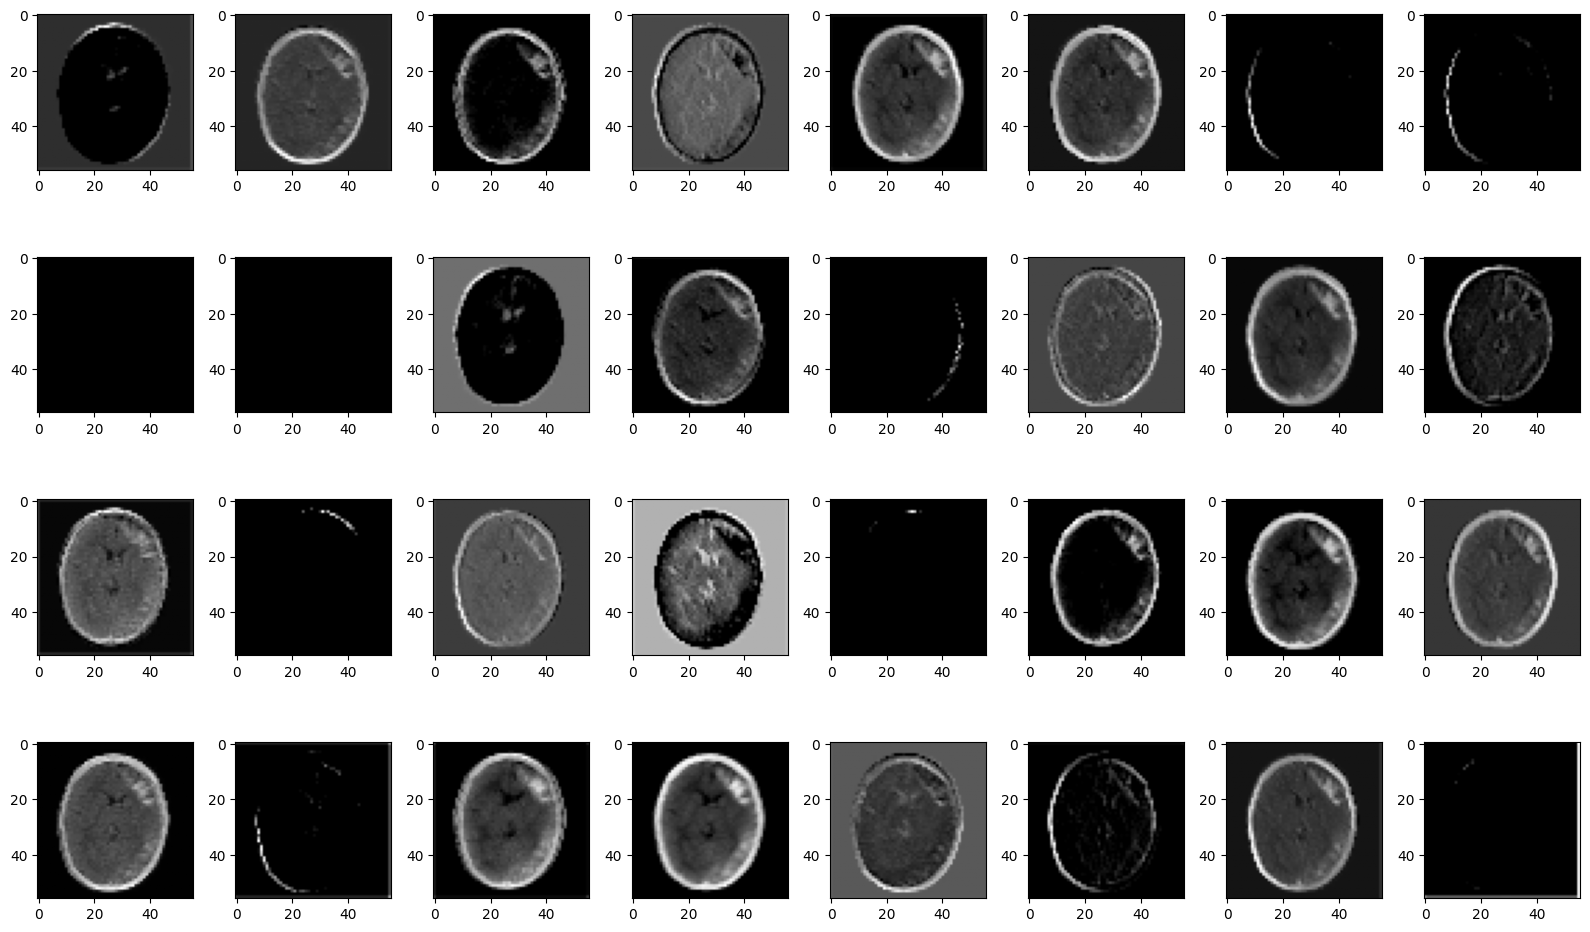

In [29]:
test_model = TumorClassifier(Fin = 100352, dg = 3, nk = nk, nm = nm, Fout = doutput, bias = True).to(device)
test_model.load_state_dict(torch.load('./brainimg'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
# Extract the feature map output from the pre-trained model

eval_model = test_model.features
imgstack = eval_model(X_train[0])

plt.figure(figsize= (16,10))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(imgstack[i].detach().numpy(), cmap=plt.get_cmap('gray'))

plt.tight_layout()
plt.savefig('Brainimg_2.png')
plt.show()

In [40]:
with torch.no_grad():
    eval_model.eval()
    X_train_feature = eval_model(X_train)
    X_test_feature = eval_model(X_test)

In [48]:
brain_feature_dict = {
        'X_train': X_train_feature,
        'X_test': X_test_feature,
        'y_train': y_train,
        'y_test': y_test
    }

torch.save(brain_feature_dict, 'brain_feature_dict.pt')


torch.Size([500])